In [1]:
from back_algorithm_update import *
import numpy as np

In [2]:
def display_pp_ori_visualization(pp_vis, ori_vis, chart_type):
    """
    Displays the original and privacy-preserving versions of a chart side by side.

    Args:
        pp_vis (np.array): A 2D numpy array representing the privacy-preserving version of the chart.
        ori_vis (np.array): A 2D numpy array representing the original version of the chart.
        chart_type (str): A string indicating the type of the chart (e.g., 'bar chart', 'pie chart').

    Returns:
        None
    """
    f, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].set_title(f"Original {chart_type}", fontsize=20)
    axs[0].imshow(ori_vis)
    axs[0].get_xaxis().set_ticks([])
    axs[0].get_yaxis().set_ticks([])

    axs[1].set_title(f"Privacy-Preserving {chart_type}", fontsize=20)
    axs[1].imshow(pp_vis)
    axs[1].get_xaxis().set_ticks([])
    axs[1].get_yaxis().set_ticks([])
    plt.show()
    
def add_contour(image, output, lum_sim, bg_avg_rgb, radius, fg):
    """
    Adds contours to the image, modifies the image to include the privacy-preserving contours, 
    and returns the resulting image.

    Args:
        image (np.array): A 2D numpy array representing the input image.
        output (np.array): A 2D numpy array representing the output image.
        lum_sim (int): The luminance similarity value.
        bg_avg_rgb (tuple): A tuple representing the average RGB value of the background.
        radius (int): The radius of the contour.
        fg (np.array): A 2D numpy array representing the foreground image.

    Returns:
        result (np.array): A 2D numpy array representing the resulting image with added contours.
    """
    result = np.copy(output)
    mask_area = radius*2+1
    fg_pad = np.pad(fg, radius)
    contours, _ = get_contours(fg_pad)
    filter_contours = contours
    ori_contour = draw_contour(fg_pad, contours)


    if mask_area == 1:
        tgt_contour = proc_contour(ori_contour, filter_contours, radius)
    else:
        tgt_contour = proc_contour(ori_contour, filter_contours, radius)[radius:-radius, radius:-radius]
    if radius != 0:
        ori_contour = ori_contour[radius:-radius, radius:-radius]
    # empirical value for lum_sim
    lum_sim = 50
    output2 = get_privacy_result(image, tgt_contour, fg, bg_avg_rgb, lum_sim)
    output2 = (lab2rgb(output2)*255.0).astype(np.uint8)
    result[ori_contour.astype(np.bool_)] = output2[ori_contour.astype(np.bool_)]
    
    return result

def get_pp(image, mask_area, lum_sim, radius, bright_size, bg_avg_rgb, bg_avg_lab, fg1, fg2):
    """
    Generates a privacy-protected version of the image by adding contours and running OCR.

    Args:
        image (np.array): A 2D numpy array representing the input image.
        mask_area (int): The size of the mask area.
        lum_sim (int): The luminance similarity value.
        radius (int): The radius of the contour.
        bright_size (int): The size of the bright area in the mask.
        bg_avg_rgb (tuple): A tuple representing the average RGB value of the background.
        bg_avg_lab (tuple): A tuple representing the average Lab color space value of the background.
        fg1 (np.array): A 2D numpy array representing the first foreground image.
        fg2 (np.array): A 2D numpy array representing the second foreground image.

    Returns:
        output (np.array): A 2D numpy array representing the privacy-protected image.
    """
    mask = grid_gen(image, mask_area, bright_size, pattern=2)
    output = get_privacy_result(image, mask, fg2, bg_avg_rgb, lum_sim)
    output = (lab2rgb(output)*255.0).astype(np.uint8)

    output = add_contour(image, output, lum_sim, bg_avg_rgb, radius, fg=fg1)
    output, _ = run_ocr_in_chart(image, output, bg_avg_lab, bboxes=None)

    return output

# Bar Chart

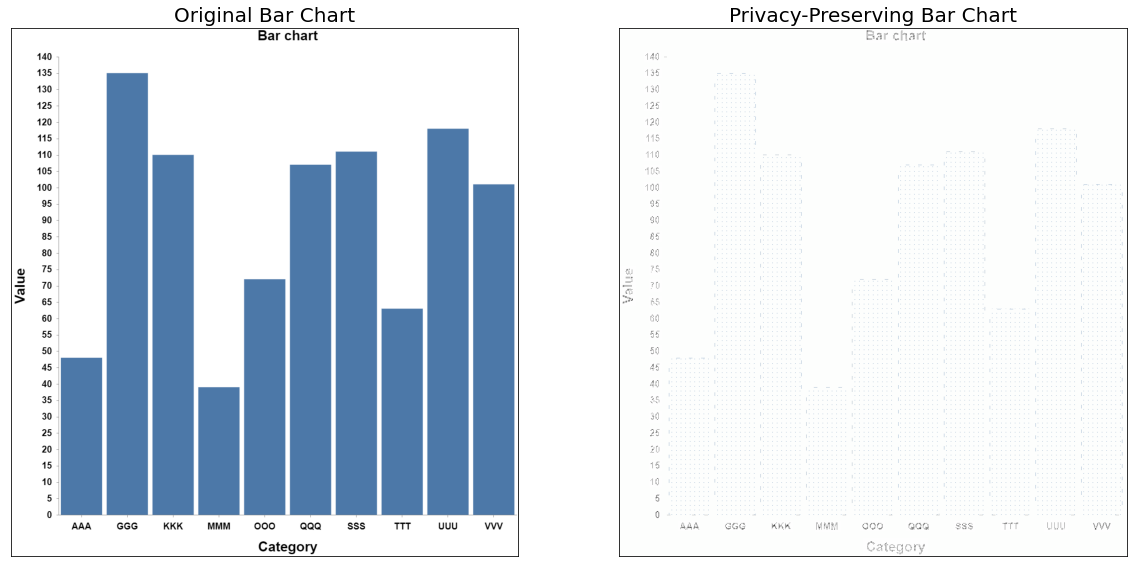

In [106]:
bar_img = cv2.imread('./visualization examples/bar.png')
bar_img = cv2.cvtColor(bar_img, cv2.COLOR_BGR2RGB)
if np.max(bar_img)<=1:
    bar_img = (bar_img*255).astype(np.uint8)
tgt_img = rgb2gray(bar_img)

# obtain the foreground of line-based element
thresh1 = filters.threshold_local(cv2.GaussianBlur(tgt_img, (3,3), 0))
fg1 = tgt_img < thresh1

# obtain the foreground of area-based element
thresh2 = filters.threshold_li(tgt_img)
bg = tgt_img >= thresh2
fg2 = tgt_img < thresh2

# obtain the background color
bg_area, fg_area = segment_bg(bar_img)
bg_avg_lab = np.mean(rgb2lab(bar_img[bg_area]),axis=0)
bg_avg_rgb= np.mean(bar_img[bg_area],axis=0)

# set the parameters empirically
radius = 24
mask_area = 10
lum_sim = 50
bright_size = 1
result = get_pp(bar_img, mask_area, lum_sim, radius, bright_size, bg_avg_rgb, bg_avg_lab, fg1, fg2)
display_pp_ori_visualization(result, bar_img, "Bar Chart")

# Pie Chart

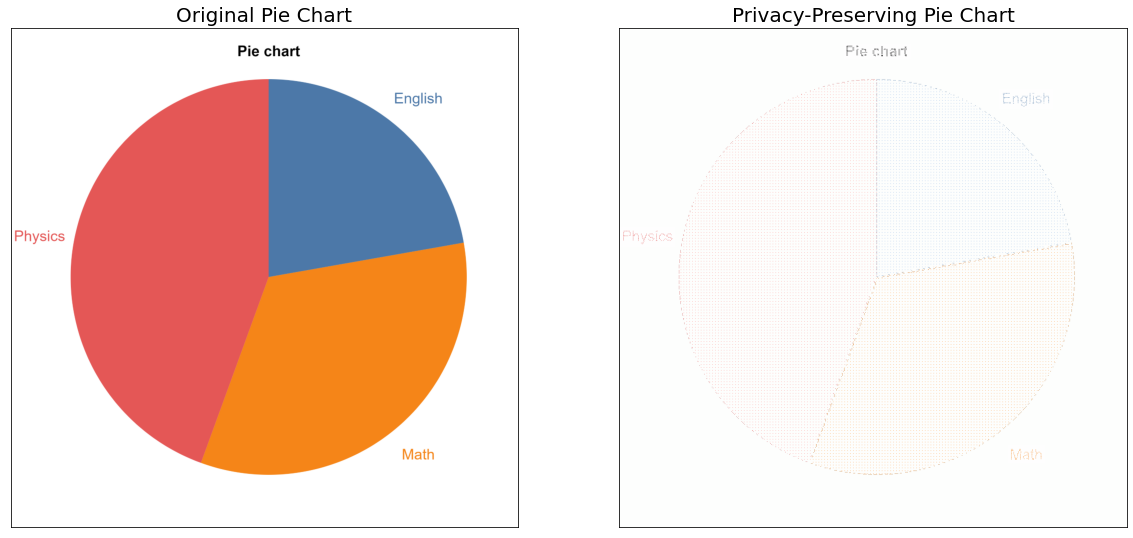

In [109]:
pie_image = cv2.imread('./visualization examples/pie.png')
pie_image = cv2.cvtColor(pie_image, cv2.COLOR_BGR2RGB)
if np.max(pie_image)<=1:
    pie_image = (pie_image*255).astype(np.uint8)
tgt_img = rgb2gray(pie_image)

# obtain the foreground of line-based element
thresh1 = filters.threshold_local(cv2.GaussianBlur(tgt_img, (3,3), 0))
fg1 = tgt_img < thresh1

# obtain the foreground of area-based element
thresh2 = filters.threshold_li(tgt_img)
bg = tgt_img >= thresh2
fg2 = tgt_img < thresh2

# obtain the background color
bg_area, fg_area = segment_bg(pie_image)
bg_avg_lab = np.mean(rgb2lab(pie_image[bg_area]),axis=0)
bg_avg_rgb= np.mean(pie_image[bg_area],axis=0)

# set the parameters empirically
radius = 8
mask_area = 6
lum_sim = 70
bright_size = 1
result = get_pp(pie_image, mask_area, lum_sim, radius, bright_size, bg_avg_rgb, bg_avg_lab, fg1, fg2)
display_pp_ori_visualization(result, pie_image, "Pie Chart")

# Scatter 

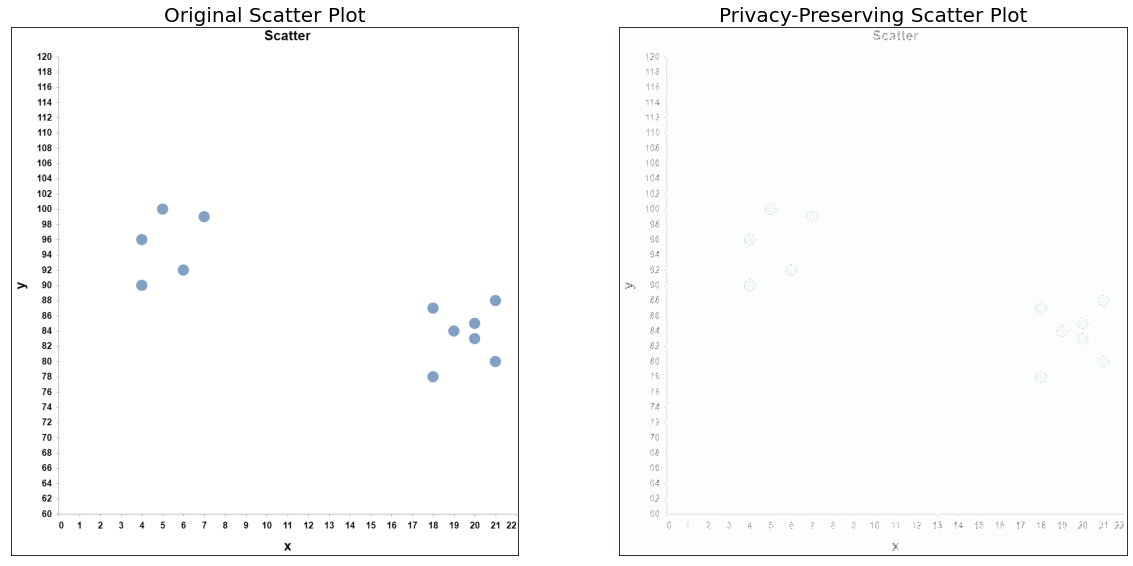

In [114]:
scatter_img = cv2.imread('./visualization examples/scatter.png')
scatter_img = cv2.cvtColor(scatter_img, cv2.COLOR_BGR2RGB)
if np.max(scatter_img)<=1:
    scatter_img = (scatter_img*255).astype(np.uint8)
tgt_img = rgb2gray(scatter_img)

# obtain the foreground of line-based element
thresh1 = filters.threshold_local(cv2.GaussianBlur(tgt_img, (3,3), 0))
fg1 = tgt_img < thresh1

# obtain the foreground of area-based element
thresh2 = filters.threshold_li(tgt_img)
bg = tgt_img >= thresh2
fg2 = tgt_img < thresh2

# obtain the background color
bg_area, fg_area = segment_bg(scatter_img)
bg_avg_lab = np.mean(rgb2lab(scatter_img[bg_area]),axis=0)
bg_avg_rgb= np.mean(scatter_img[bg_area],axis=0)

# set the parameters empirically
radius = 6
mask_area = 5
lum_sim = 50
bright_size = 1
result = get_pp(scatter_img, mask_area, lum_sim, radius, bright_size, bg_avg_rgb, bg_avg_lab, fg1, fg2)
display_pp_ori_visualization(result, scatter_img, "Scatter Plot")